In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Train/Val/Test - 0.65:0.20:0.15
# CPU - Intel(R) Xeon(R) CPU @ 2.30GHz
# GPU - Tesla K80

In [2]:
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, BatchNormalization, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import decode_predictions, preprocess_input, ResNet50
import pandas as pd
import numpy as np
import seaborn as sn

In [3]:
img_gen = ImageDataGenerator(preprocessing_function = preprocess_input, horizontal_flip = True, vertical_flip = True)

In [4]:
train_data = img_gen.flow_from_directory("/content/drive/MyDrive/UROV_dataset/output/train", target_size = (224,224), class_mode = "binary", batch_size = 32)
valid_data = img_gen.flow_from_directory("/content/drive/MyDrive/UROV_dataset/output/val", target_size = (224,224), class_mode = "binary", batch_size = 32, classes = train_data.class_indices)
test_data = img_gen.flow_from_directory("/content/drive/MyDrive/UROV_dataset/output/test", target_size = (224,224), class_mode = "binary", batch_size = 1, classes = train_data.class_indices)

Found 1530 images belonging to 2 classes.
Found 470 images belonging to 2 classes.
Found 355 images belonging to 2 classes.


In [5]:
base_model = ResNet50(include_top = False, weights = "imagenet", input_shape = (224,224,3))

for layer in base_model.layers :
  layer.trainable = False

for layer in base_model.layers[-1:] :
  layer.trainable = True

x = base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(128, activation = "relu")(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
pred = Dense(1, activation = "sigmoid")(x)

model = Model(inputs = base_model.input, outputs = pred)

In [ ]:
model.summary()

In [6]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [7]:
import tensorflow as tf

with tf.device("/gpu:1") :
  history = model.fit(train_data, epochs = 15, validation_data = valid_data)

Epoch 1/15
48/48 [==============================] - 24s 363ms/step - loss: 0.2872 - accuracy: 0.8824 - val_loss: 0.2285 - val_accuracy: 0.9574
Epoch 2/15
48/48 [==============================] - 14s 298ms/step - loss: 0.1466 - accuracy: 0.9510 - val_loss: 0.1182 - val_accuracy: 0.9681
Epoch 3/15
48/48 [==============================] - 14s 298ms/step - loss: 0.1111 - accuracy: 0.9588 - val_loss: 0.1032 - val_accuracy: 0.9723
Epoch 4/15
48/48 [==============================] - 14s 299ms/step - loss: 0.0734 - accuracy: 0.9745 - val_loss: 0.0975 - val_accuracy: 0.9617
Epoch 5/15
48/48 [==============================] - 14s 299ms/step - loss: 0.0742 - accuracy: 0.9752 - val_loss: 0.1004 - val_accuracy: 0.9511
Epoch 6/15
48/48 [==============================] - 14s 299ms/step - loss: 0.0589 - accuracy: 0.9797 - val_loss: 0.0935 - val_accuracy: 0.9702
Epoch 7/15
48/48 [==============================] - 14s 298ms/step - loss: 0.0433 - accuracy: 0.9843 - val_loss: 0.0910 - val_accuracy: 0.9702

In [61]:
model.evaluate(train_data)

48/48 [==============================] - 11s 221ms/step - loss: 0.0044 - accuracy: 1.0000


[0.004366893786936998, 1.0]

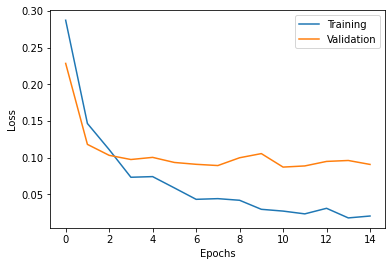

In [9]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

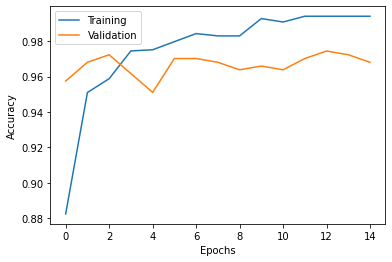

In [10]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

In [30]:
y_pred = []
y_act = []

test_data.reset()

for i in range(len(test_data.filenames)) :
  x, y = test_data.next()
  y_act.append(int(y))
  y_pred.append(round(model.predict(x)[0][0]))

In [38]:
pred_list = [list(test_data.class_indices.keys())[i] for i in y_pred]
act_list = [list(test_data.class_indices.keys())[i] for i in y_act]

In [50]:
data = pd.DataFrame(np.vstack([pred_list, act_list]).T, columns = ["Barnacles", "non-Barnacles"])

In [52]:
confusion_matrix = pd.crosstab(data["Barnacles"], data["non-Barnacles"], rownames = ["Actual"], colnames = ["Predicted"])

In [53]:
confusion_matrix

Predicted,barnacles,non_barnacles
Actual,,
barnacles,147,10
non_barnacles,7,191


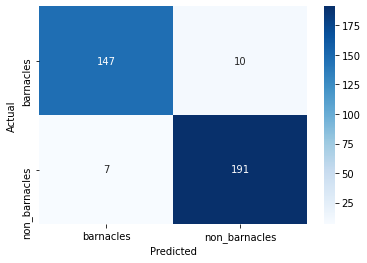

In [60]:
sn.heatmap(confusion_matrix, annot = True, fmt = "d", cmap = "Blues")

In [62]:
from sklearn.metrics import classification_report

In [63]:
print(classification_report(y_act, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       154
           1       0.96      0.95      0.96       201

    accuracy                           0.95       355
   macro avg       0.95      0.95      0.95       355
weighted avg       0.95      0.95      0.95       355

